In [1]:
# Het importeren van de nodige packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import plotly.express as px
import cufflinks as cf
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Business understanding
Het ziekenhuis Isala wil de zorg voor diabetespatiënten verbeteren. Het gaat hier specifiek om het behandelproces door onnauwkeurigheden in metingen te filteren en hierop te baseren of een behandelplan aangepast moet worden of niet. Visualisaties zullen helpen bij het verkrijgen van inzicht van diverse meetmethoden om vervolgens conclusies te kunnen trekken. Die zijn er nog niet. deze onnauwkeurigheden voor aangegeven als CV. De CV is de variatiecoëfficiënt. Dit is een maat voor de relatieve variabiliteit. Het is de verhouding tussen de standaardafwijking en het gemiddelde (gemiddelde genomen van de spreiding van meetpunten). Hoe kleiner de variatiecoëfficiënt is, hoe minder de gegevens verspreid zijn vanuit het gemiddelde.

Variatiecoëfficiënt = (Standaardafwijking/ Gemiddelde) * 100.

De complete data understanding staat in de oplevering als: "Business understanding hba1c"

 
# Data understanding
Welke databronnen zijn gegeven en in welk formaat: Een excel bestand genaamd: Complete-dataset-FINAL.xlsx

Het excel bestand dat gebruikt gaat worden, is het resultaat van rapporten die om zijn gezet naar excel. Dit is de meest recente versie waarin de meetmethoden zijn genormaliseerd en de waarden dubbelgecheckt zijn. Deze dataset is dus speciaal omgezet om duidelijkere en completere visualisaties neer te zetten. Dit is daarom ook een dataset die NIET voor andere projecten gebruikt kan worden, daarvoor verwijs ik graag naar een ander excel bestand die we ook hebben omgezet maar niet aan de meetmethode naamgeving hebben gezeten.

Hoe groot zijn deze databronnen: 355 kB

-4685 rijen

-12 kolommen

Kolomnamen: Method name, N (no. labs), Mean, Bias, CV, Sample, Reference value, Year, Source, Type, Manufacturer (fabrikant).

# Data preparation
De dataset wordt aangepast, zodat het bruikbaar is om de bepaalde visualisaties te ontwikkelen, onze product owner wilde distinctie tussen de 2 verschillende surveys (CAP & eura1c)

De dataset die we gaan gebruiken

In [2]:
df = pd.read_excel('Complete-dataset-final.xlsx')
df = df.dropna()

Data voor de CV grafiek van de eura1c en CAP data samengevoegd

In [3]:
df_fout = df.groupby(['Method name','Year']).mean().reset_index().set_index('Method name')

Alleen de CAP data, dit wordt voor meer data preparation gebruikt en de CAP predictie

In [4]:
df_CAP_prep = df.loc[df['Source (CAP/EurA1c)'] == 'CAP']

Alleen de eura1c data, dit wordt voor meer data preperation gebruikt en de CAP predictie

In [5]:
df_eura1c_prep = df.loc[df['Source (CAP/EurA1c)'] == 'EURA1c']

Data voor de CV grafiek van alleen de CAP data

In [6]:
# Gemiddelde waardes CV pakken per methode per jaar
df_CAP = df_CAP_prep.groupby(['Method name','Year']).mean().reset_index().set_index('Method name')
# Overige kolommen droppen
df_CAP = df_CAP.drop(columns = ['Bias','Reference Value','Total Error','Mean'])

Data voor de CV grafiek van alleen de eura1c data

In [7]:
# Gemiddelde waardes CV pakken per methode per jaar
df_eura1c = df_eura1c_prep.groupby(['Method name','Year']).mean().reset_index().set_index('Method name')
# Overige kolommen droppen
df_eura1c = df_eura1c.drop(columns = ['Bias','Reference Value','Total Error','Mean'])

Data voor regressieplot van alle CAP data

In [8]:
# Gemiddelde waardes CV pakken per jaar
df_CAP_all = df_CAP_prep.groupby(['Year']).mean().reset_index()
# Overige kolommen droppen
df_CAP_all  = df_CAP_all.drop(columns = ['Bias','Reference Value','Total Error','Mean'])

Data voor regressieplot van alle eura1c data

In [9]:
# Gemiddelde waardes CV pakken per jaar
df_eura1c_all  = df_eura1c_prep.groupby(['Year']).mean().reset_index()
# Overige kolommen droppen
df_eura1c_all = df_eura1c_all.drop(columns = ['Bias','Reference Value','Total Error','Mean'])

Alleen de manufacturers die meer dan 100 datapunten hebben pakken (Om ervoor te zorgen dat we geen manufacturers pakken die maar data hebben van 1 jaar)

In [10]:
# Groupby manufacturer
df_best = df.groupby('Manufacturer')
# Orderen manufacturer op aantal datapunten
test = df_best.size().sort_values(ascending=False)
# Alle manufacturers met meer dan 100 datapunten pakken
test = test[test > 100]

Data voor de barplot met beste manufacturers uit de CAP data

In [11]:
# Alle data pakken met de manufactuers die meer dan 100 datapunten hebben
df_manufacturer_CAP = df[df['Manufacturer'].isin(test.index)]
# Alleen de CAP manufacturers pakken
df_manufacturer_CAP = df_manufacturer_CAP[df_manufacturer_CAP['Source (CAP/EurA1c)'] == 'CAP']
# Overige kolommen droppen
df_manufacturer_CAP = df_manufacturer_CAP.drop(columns=['Mean','Bias','Total Error','Reference Value','Year'])
# Gemiddelde waardes CV pakken per manufacturer
df_manufacturer_CAP = df_manufacturer_CAP.groupby('Manufacturer').mean()
# Sorteren op CV
df_manufacturer_CAP = df_manufacturer_CAP.sort_values(by = 'CV').reset_index()

Data voor de barplot met beste manufacturers uit de eura1c data

In [12]:
# Alle data pakken met de manufactuers die meer dan 100 datapunten hebben
df_manufacturer_eura1c = df[df['Manufacturer'].isin(test.index)]
# Alleen de eura1c manufacturers pakken
df_manufacturer_eura1c = df_manufacturer_eura1c[df_manufacturer_eura1c['Source (CAP/EurA1c)'] == 'EURA1c']
# Overige kolommen droppen
df_manufacturer_eura1c = df_manufacturer_eura1c.drop(columns=['Mean','Bias','Total Error','Reference Value','Year'])
# Gemiddelde waardes CV pakken per manufacturer
df_manufacturer_eura1c = df_manufacturer_eura1c.groupby('Manufacturer').mean()
# Sorteren op CV
df_manufacturer_eura1c = df_manufacturer_eura1c.sort_values(by = 'CV').reset_index()

Data voor de CV grafiek van Beckman coulter CAP

In [13]:
# Alleen de Beckman Coulter data pakken
beckman_cv_CAP = df_CAP_prep[df_CAP_prep['Manufacturer'] == 'Beckman Coulter']
# Gemiddelde waardes CV pakken per jaar
beckman_cv_CAP = beckman_cv_CAP.groupby('Year').mean().reset_index()
# Overige kolommen droppen
beckman_cv_CAP = beckman_cv_CAP.drop(columns= ['Mean','Bias','Reference Value','Total Error'])

Data voor de CV grafiek van Beckman coulter eura1c

In [14]:
# Alleen de Beckman Coulter data pakken
beckman_cv_eura1c = df_eura1c_prep[df_eura1c_prep['Manufacturer'] == 'Beckman Coulter']
# Gemiddelde waardes CV pakken per jaar
beckman_cv_eura1c = beckman_cv_eura1c.groupby('Year').mean().reset_index()
beckman_cv_CAP = beckman_cv_CAP.groupby('Year').mean().reset_index()
# Overige kolommen droppen
beckman_cv_eura1c = beckman_cv_eura1c.drop(columns= ['Mean','Bias','Reference Value','Total Error'])

# Modeling

Een functie om een lijngrafiek te plotten van de CV per methode per jaar voor de CAP en eura1c data gecombineerd 

In [15]:
def plotCV_fout(method):
    df_fout.loc[[method]].iplot(
                    xTitle='Year',
                    x = 'Year',
                    y = 'CV',
                    mode='lines+markers',
                    yTitle='CV {}'.format(method),
                    xaxis_range=[2006,2021],
                    title = 'Average CV per Year FOUT'
        
                     )

Een functie om een lijngrafiek te plotten van de CV per methode per jaar voor de CAP data

In [16]:
def plotCV_CAP(method):
    df_CAP.loc[[method]].iplot(
                    xTitle='Year',
                    x = 'Year',
                    y = 'CV',
                    mode='lines+markers',
                    yTitle='CV {}'.format(method),
                    xaxis_range=[2006,2021],
                    title = 'Average CV per Year CAP'
        
                     )

Een functie om een lijngrafiek te plotten van de CV per methode per jaar voor de eura1c data

In [17]:
def plotCV_eura1c(method):
    df_eura1c.loc[[method]].iplot(
                    xTitle='Year',
                    x = 'Year',
                    y = 'CV',
                    mode='lines+markers',
                    yTitle='CV {}'.format(method),
                    xaxis_range=[2016,2020],
                    title = 'Average CV per Year eura1c'
        
                     )

De lijngrafiek van de CV per methode per jaar voor de CAP en eura1c data gecombineerd. Met een dropdown om de bepaalde methode te selecteren

In [18]:
interact(plotCV_fout, method=df_fout.index.unique())

interactive(children=(Dropdown(description='method', options=('A1cNOW', 'Abbott Alinity', 'Abbott Alinity ci s…

<function __main__.plotCV_fout(method)>

De lijngrafiek van de CV per methode per jaar voor de CAP data. Met een dropdown om de bepaalde methode te selecteren

In [19]:
interact(plotCV_CAP, method=df_CAP.index.unique())

interactive(children=(Dropdown(description='method', options=('A1cNOW', 'Abbott Alinity ci series', 'Abbott Ar…

<function __main__.plotCV_CAP(method)>

De lijngrafiek van de CV per methode per jaar voor de eura1c data. Met een dropdown om de bepaalde methode te selecteren

In [20]:
interact(plotCV_eura1c, method=df_eura1c.index.unique())

interactive(children=(Dropdown(description='method', options=('Abbott Alinity', 'Abbott Architect', 'Abbott Ar…

<function __main__.plotCV_eura1c(method)>

Regressie plot van alle CV waardes gemiddeld per jaar van de CAP data

Text(0.5, 1.0, 'gemiddelde CV waardes CAP')

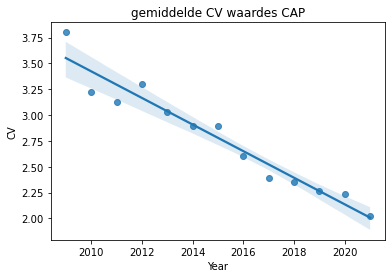

In [21]:
sns.regplot(data=df_CAP_all, x = 'Year', y = 'CV').set_title('gemiddelde CV waardes CAP')

We zien hier dat er een sterk dalend linear verband is, daarom is het interessant om hier een predictief model voor te gebruiken om het jaar 2022 te voorspellen

Text(0.5, 1.0, 'confusion matrix CAP data')

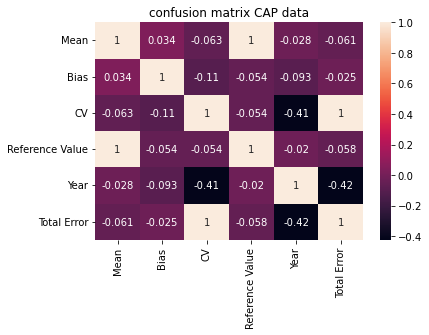

In [22]:
sns.heatmap(df_CAP_prep.corr(), annot=True).set_title('confusion matrix CAP data')

Uit deze correlatie matrix kunnen we halen dat de beste waarde om CV te voorspellen Year is, total error scoort een 1 wat perfect is maar dit komt omdat de total error een afgeleide van CV is.

Om het jaar 2022 te voorspellen hebben we een autoregressie model gebruikt

Hier gebruiken we de data van alle jaren

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     CV   R-squared (uncentered):                   0.871
Model:                            OLS   Adj. R-squared (uncentered):              0.871
Method:                 Least Squares   F-statistic:                          2.397e+04
Date:                Mon, 20 Jun 2022   Prob (F-statistic):                        0.00
Time:                        11:21:25   Log-Likelihood:                         -5037.3
No. Observations:                3544   AIC:                                  1.008e+04
Df Residuals:                    3543   BIC:                                  1.008e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year           0.0013   8.35e-06    154.817      0.000       0.001       0.001
==============================================================================
Omnibus:                     1323.667   Durbin-Watson:                   0.640
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7747.228
Skew:                           1.668   Prob(JB):                         0.00
Kurtosis:                       9.429   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

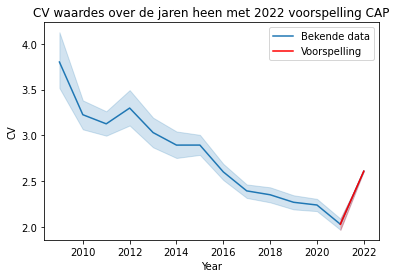

In [23]:
# Afhankelijke en onafhankelijke variabele toekennen
X = df_CAP_prep['Year']
y = df_CAP_prep["CV"]
# Het model fitten en predictie maken
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
# Maak een nieuwe dataframe aan die de voorspellende waarde bevat in het jaar 2022
preddf = pd.DataFrame(predictions, columns=['CV'])
preddf['Year'] = "2022"
# Voeg het nieuwe dataframe toe aan de oude
combined = pd.concat([df_CAP_prep,preddf])
combined['Year'] = combined['Year'].astype(str).astype(int)
# Reset index omdat index niet meer kloppend is
combined = combined.reset_index(drop=True)
# Plot de CV waarde per jaar in een lijngrafiek
sns.lineplot(x = 'Year', y = 'CV', data = combined)
# Maak het voorspelde jaar een andere kleur
sns.lineplot(x = 'Year', y = 'CV', data = combined[(combined['Year'] >= 2021) & (combined['Year'] <= 2022)], color= 'red').set_title('CV waardes over de jaren heen met 2022 voorspelling CAP')
plt.legend(labels=["Bekende data","Voorspelling"])
model.summary()

#### Interpretatie van het model
Het model scoort met een R-squared waarde van 0.871 redelijk hoog, met de R-squared alleen kunnen we niet er gelijk vanuit gaa ndat het een goed model is. De P>|t| waarde is 0 dit is excellent en laat zien dat er 0% kans is dat jaar geen invloed heeft op de CV. 

De scores van het model scoren dus hoog en dit zou dus een sterk model moeten maken, wanneer we naar de grafiek kijken zien we alleen dat dit niet het geval is. Er is een aardig duidelijke trend naar beneden met CV waardes over de afgelopen jaren, wanneer we de CV proberen te voorspellen schiet de lijn opeens weer omhoog. Onze hypothese is dat omdat we alleen de jaren als variable gebruiken dat er een soort gemiddelde gepakt word en daarom de CV dus weer omhoog gaat.

Dit maakt het dus geen gode predictie en met de data die beschikbaar is, is een betere predicitie ook niet mogelijk met een regressie model. Een model wat meer toepasbaar zou zijn zou eventueel een time series analysis zijn.

Hier gebruiken we de data van 2018 tot 2021

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     CV   R-squared (uncentered):                   0.905
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                          1.380e+04
Date:                Mon, 20 Jun 2022   Prob (F-statistic):                        0.00
Time:                        11:21:26   Log-Likelihood:                         -1591.1
No. Observations:                1457   AIC:                                      3184.
Df Residuals:                    1456   BIC:                                      3190.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year           0.0011   9.36e-06    117.476      0.000       0.001       0.001
==============================================================================
Omnibus:                      102.570   Durbin-Watson:                   0.713
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.372
Skew:                           0.669   Prob(JB):                     9.84e-28
Kurtosis:                       3.510   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

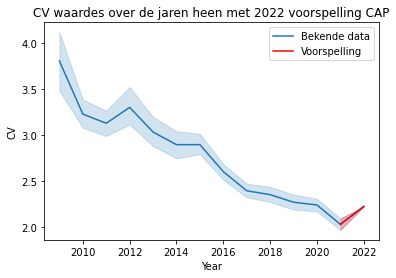

In [24]:
# Alleen het jaar 2018 en hoger pakken
CAP_prep_pred = df_CAP_prep[df_CAP_prep["Year"] >= 2018]
# Afhankelijke en onafhankelijke variabele toekennen
X = CAP_prep_pred['Year']
y = CAP_prep_pred["CV"]
# Het model fitten en predictie maken
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
# Maak een nieuwe dataframe aan die de voorspellende waarde bevat in het jaar 2022
preddf = pd.DataFrame(predictions, columns=['CV'])
preddf['Year'] = "2022"
# Voeg het nieuwe dataframe toe aan de oude
combined = pd.concat([df_CAP_prep,preddf])
combined['Year'] = combined['Year'].astype(str).astype(int)
# Reset index omdat index niet meer kloppend is
combined = combined.reset_index(drop=True)
# Plot de CV waarde per jaar in een lijngrafiek
sns.lineplot(x = 'Year', y = 'CV', data = combined)
# Maak het voorspelde jaar een andere kleur
sns.lineplot(x = 'Year', y = 'CV', data = combined[(combined['Year'] >= 2021) & (combined['Year'] <= 2022)], color= 'red').set_title('CV waardes over de jaren heen met 2022 voorspelling CAP')
plt.legend(labels=["Bekende data","Voorspelling"])
model.summary()

#### Intrepretatie model
Om verder te gaan op de hypothese van het vorige model hebben we hetzelfde model uitgevoerd alleen dan vanaf het jaar 2018 in plaats van alle jaren. De R-squared is iets omhoog gegaan van 0.871 naar 0.905 en de P>|t| is nog steeds 0. Maakt dit het model beter dan de vorige? nee, er zit nog steeds stijging in de lijn wat erg onwaarschijnlijk is. Wel is de lijn minder sterk stijgend. Dit gaat alleen maar verder op onze hypothese dat het model een soort gemiddelde pakt van de vorige jaren sinds de algehele CV waardes vanaf 2018 lager zijn dan in de jaren ervoor.

Regressie plot van alle CV waardes gemiddeld per jaar van de eura1c data

Text(0.5, 1.0, 'gemiddelde CV waardes eura1c')

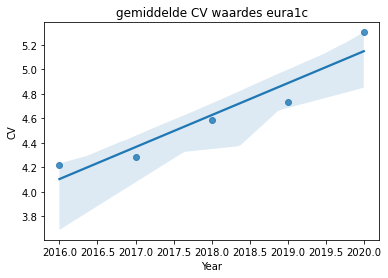

In [25]:
sns.regplot(data=df_eura1c_all, x = 'Year', y = 'CV').set_title('gemiddelde CV waardes eura1c')

We zien hier dat er een sterk stijgend linear verband is, daarom is het interessant om hier een predictief model voor te gebruiken om het jaar 2021 te voorspellen

Text(0.5, 1.0, 'confusion matrix eura1c data')

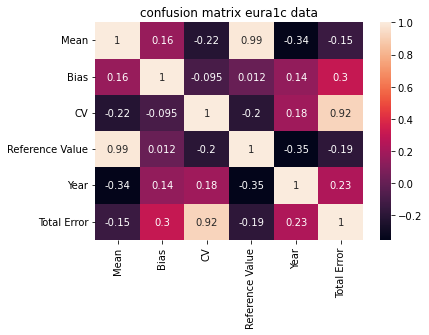

In [26]:
sns.heatmap(df_eura1c_prep.corr(), annot=True).set_title('confusion matrix eura1c data')

Uit deze correlatie matrix kunnen we halen dat er geen goede data is om de CV te voorspellen, total error scoort een 0.92 wat  bijna perfect is maar dit komt omdat de total error een afgeleide van CV is. Om de voorspelling te doen zullen we daarom Year gebruiken om het gelijk te houden met de CAP data predictie

Om het jaar 2021 te voorspellen hebben we een autoregressie model gebruikt

Hier gebruiken we de data van alle jaren

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     CV   R-squared (uncentered):                   0.830
Model:                            OLS   Adj. R-squared (uncentered):              0.830
Method:                 Least Squares   F-statistic:                              2511.
Date:                Mon, 20 Jun 2022   Prob (F-statistic):                   8.84e-200
Time:                        11:21:27   Log-Likelihood:                         -1118.0
No. Observations:                 514   AIC:                                      2238.
Df Residuals:                     513   BIC:                                      2242.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year           0.0023   4.66e-05     50.114      0.000       0.002       0.002
==============================================================================
Omnibus:                      156.738   Durbin-Watson:                   0.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              440.957
Skew:                           1.481   Prob(JB):                     1.77e-96
Kurtosis:                       6.438   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

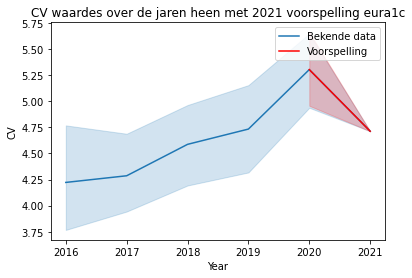

In [27]:
# Afhankelijke en onafhankelijke variabele toekennen
X = df_eura1c_prep['Year']
y = df_eura1c_prep["CV"]
# Het model fitten en predictie maken
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
# Maak een nieuwe dataframe aan die de voorspellende waarde bevat in het jaar 2021
preddf = pd.DataFrame(predictions, columns=['CV'])
preddf['Year'] = "2021"
# Voeg het nieuwe dataframe toe aan de oude
combined = pd.concat([df_eura1c_prep,preddf])
combined['Year'] = combined['Year'].astype(str).astype(int)
# Reset index omdat index niet meer kloppend is
combined = combined.reset_index(drop=True)
# Plot de CV waarde per jaar in een lijngrafiek
sns.lineplot(x = 'Year', y = 'CV', data = combined)
# Maak het voorspelde jaar een andere kleur
sns.lineplot(x = 'Year', y = 'CV', data = combined[(combined['Year'] >= 2020) & (combined['Year'] <= 2021)], color= 'red').set_title('CV waardes over de jaren heen met 2021 voorspelling eura1c')
plt.legend(labels=["Bekende data","Voorspelling"])
model.summary()

Het model scoort met een R-squared waarde van 0.830 redelijk hoog, met de R-squared alleen kunnen we niet er gelijk vanuit gaa ndat het een goed model is. De P>|t| waarde is 0 dit is excellent en laat zien dat er 0% kans is dat jaar geen invloed heeft op de CV.

De scores van het model scoren dus hoog en dit zou dus een sterk model moeten maken, wanneer we naar de grafiek kijken zien we alleen dat dit niet het geval is. Er is een aardig duidelijke trend naar boven met CV waardes over de afgelopen jaren, wanneer we de CV proberen te voorspellen schiet de lijn opeens weer omlaag. Onze hypothese is dat omdat we alleen de jaren als variable gebruiken dat er een soort gemiddelde gepakt word en daarom de CV dus weer omhoog gaat.

Dit maakt het dus geen gode predictie en met de data die beschikbaar is, is een betere predicitie ook niet mogelijk met een regressie model. Een model wat meer toepasbaar zou zijn zou eventueel een time series analysis zijn.

Hier gebruiken we de data van 2018-2020

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     CV   R-squared (uncentered):                   0.842
Model:                            OLS   Adj. R-squared (uncentered):              0.841
Method:                 Least Squares   F-statistic:                              1875.
Date:                Mon, 20 Jun 2022   Prob (F-statistic):                   2.86e-143
Time:                        11:21:28   Log-Likelihood:                         -770.82
No. Observations:                 354   AIC:                                      1544.
Df Residuals:                     353   BIC:                                      1548.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Year           0.0024   5.63e-05     43.296      0.000       0.002       0.003
==============================================================================
Omnibus:                       72.985   Durbin-Watson:                   0.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              120.931
Skew:                           1.205   Prob(JB):                     5.50e-27
Kurtosis:                       4.546   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

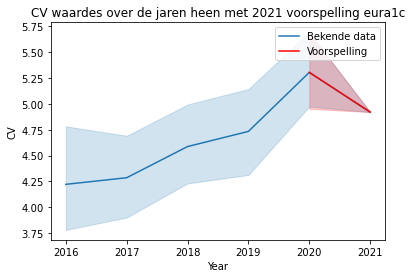

In [28]:
# Alleen het jaar 2018 en hoger pakken
eura1c_prep_pred = df_eura1c_prep[df_eura1c_prep["Year"] >= 2018]
# Afhankelijke en onafhankelijke variabele toekennen
X = eura1c_prep_pred['Year']
y = eura1c_prep_pred["CV"]
# Het model fitten en predictie maken
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
# Maak een nieuwe dataframe aan die de voorspellende waarde bevat in het jaar 2021
preddf = pd.DataFrame(predictions, columns=['CV'])
preddf['Year'] = "2021"
# Voeg het nieuwe dataframe toe aan de oude
combined = pd.concat([df_eura1c_prep,preddf])
combined['Year'] = combined['Year'].astype(str).astype(int)
# Reset index omdat index niet meer kloppend is
combined = combined.reset_index(drop=True)
# Plot de CV waarde per jaar in een lijngrafiek
sns.lineplot(x = 'Year', y = 'CV', data = combined)
# Maak het voorspelde jaar een andere kleur
sns.lineplot(x = 'Year', y = 'CV', data = combined[(combined['Year'] >= 2020) & (combined['Year'] <= 2021)], color= 'red').set_title('CV waardes over de jaren heen met 2021 voorspelling eura1c')
plt.legend(labels=["Bekende data","Voorspelling"])
model.summary()

#### Intrepretatie model
Om verder te gaan op de hypothese van het vorige model hebben we hetzelfde model uitgevoerd alleen dan vanaf het jaar 2018 in plaats van alle jaren. De R-squared is iets omhoog gegaan van 0.830 naar 0.842 en de P>|t| is nog steeds 0. Maakt dit het model beter dan de vorige? nee, er zit nog steeds daling in de lijn wat erg onwaarschijnlijk is. Wel is de lijn minder sterk dalend. Dit gaat alleen maar verder op onze hypothese dat het model een soort gemiddelde pakt van de vorige jaren sinds de algehele CV waardes vanaf 2018 lager zijn dan in de jaren ervoor.

Barplot gemiddelde CV scores per manufacturer CAP data

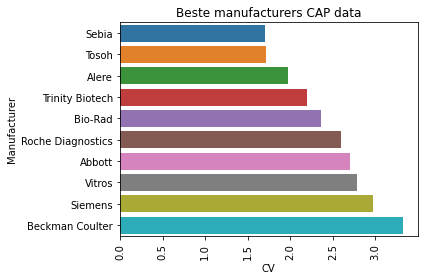

In [29]:
sns.barplot(data = df_manufacturer_CAP, x = 'CV', y = 'Manufacturer').set_title('Beste manufacturers CAP data')
plt.xticks(rotation=90)
plt.tight_layout()

Beckman coulter lijngrafiek CV waardes CAP

Text(0.5, 1.0, 'Beckman coulter CV over de jaren heen CAP')

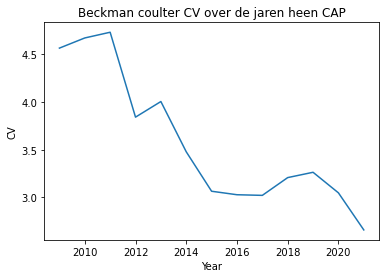

In [30]:
sns.lineplot(data = beckman_cv_CAP, x = 'Year', y = 'CV').set_title('Beckman coulter CV over de jaren heen CAP')

Barplot gemiddelde CV scores per manufacturer eura1c data

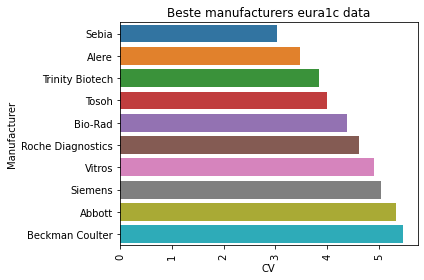

In [33]:
sns.barplot(data = df_manufacturer_eura1c, x = 'CV', y = 'Manufacturer').set_title('Beste manufacturers eura1c data')
plt.xticks(rotation=90)
plt.tight_layout()

Beckman coulter lijngrafiek CV waardes eura1c

Text(0.5, 1.0, 'Beckman coulter CV over de jaren heen eura1c')

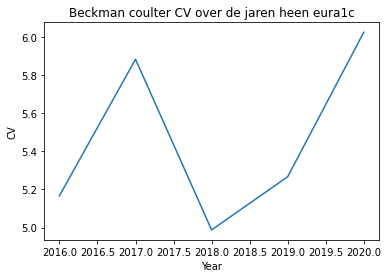

In [32]:
sns.lineplot(data = beckman_cv_eura1c, x = 'Year', y = 'CV').set_title('Beckman coulter CV over de jaren heen eura1c')

# Evaluation
#### CV waardes per methode per jaar
Onze product owner vond het belangrijk om inzicht te krijgen in hoe de methodes het over de jaren heen het deden met de cv waardes, onze data bestond uit twee verschillende surveys, de Amerikaanse(CAP) en de europeaanse(eura1c), om de cv waardes te visualiseren hadden we dan ook de cv waardes per methode per jaar het gemiddelde gepakt en dat gevisualiseerd. Na een stakeholder meeting waar we dit product opleverde kwamen we erachter dat de cv waardes van de CAP en eura1c beide anders worden berekend en opgesteld. Hierdoor waren we genoodzaakt om 2 grafieken te ontwikkelen, één van de CAP data en één van de eura1c data. Gelukkig hadden we onze dataset zo opgesteld dat in onze complete dataset een variabel was waar we hadden aangegeven of de data van de CAP of de eura1c survey was.

#### Niet complete data
Mijn eerste bevinding bij allebei de grafieken die ik kan maken is dat er veel data punten missen. Hierdoor is het lastig om nou een heel erg duidelijk beeld te krijgen hoe de methodes het nou over de jaren heen doen (sommige methodes hebben maar 1 jaar aan data en andere wel over meerdere jaren). Bijvoorbeeld bij de CAP data is de Tosoh G7 Auto HPLC goed gedocumenteerd over de jaren heen en kan je zien of de methode zich verbeterd of alleen maar slechter word. Hier kan je zien dat de CV waarde in 2017 opeens een stuk lager en dus beter werd maar in 2018 de waarde snel weer naar boven schoot, bijna terug naar ongeveer dezelfde waardes als jaren ervoor. Dit soort schommelingen komen vaker voor in de dataset en bij ons is het niet duidelijk waarom dit het geval is. Bij de CAP data zijn er dus ook incomplete datapunten, bij de Vitros 5.1 FS chem system hebben we bijvoorbeeld maar 4 datapunten, dit kan meerdere invloeden hebben; ze kunnen uit productie zijn gegaan, een nieuwe opvolger hebben gekregen of ze hebben simpelweg niet meer mee gedaan aan deze survey.

#### Trendlijn CAP en eura1c
We hebben een nieuwe grafiek gerealiseerd om de gemiddelde CV waardes van alle methoden over alle jaren heen te laten zien om te kijken of de schommelingen alleen bij de Tosoh G7 Auto HPLC voorkwamen of die bij alle methodes voorkwamen.We zagen daar dat over de jaren heen er een trend naar beneden is bij de CAP data en bij de eura1c er juist een trend naar boven is bij de laatste paar jaren. De grote schommelingen per jaar komen wel echt alleen per methode voor en niet in het algemeen over de hele dataset, we zien geen punten in de grafiek die heel erg afwijken van de regressielijn. Het is wel erg interessant hoe de CAP CV waardes naar beneden gaan en de eura1c CV waardes juist omhoog gaan.

#### CV waardes manufacturers
Mijn tweede bevinding is dat er bij de CAP en eura1c data verschillende manufacturers het beste zijn bij hun data, maar toch ook weer veel hetzelfde. De nummers 1-5 en 6-10 zijn namelijk allemaal dezelfde manufacturers maar net op een andere positie. Dit laat toch zien dat er wel duidelijk verschil zit tussen de manufacturers en hun meetafwijkingen. 

Beckman coulter presteert het slechtst bij zowel de CAP als de eura1c data, om hier verder op in te kijken hebben we 2 lijngrafieken gevisualiseerd om wat dieper in de cv waardes te kijken. In de vorige grafiek gebruikten we een gemiddelde waarde was van alle jaren, dit geeft niet het beste beeld van de manufacturer want het zou zomaar kunnen dat ze de eerste jaren slecht waren en zich de laatste paar jaren positief aan het verbeteren zijn.  

Bij de CAP data is dit inderdaad het geval, de laatste 2 jaar gaan de CV waardes omlaag maar de jaren ervoor was die waarde wel erg hoog. Het laagste data punt is wel nog steeds boven de 3, de andere manufacturers zitten gemiddeld allemaal onder de 3 dus we zien wel dat Beckman coulter de meetmethodes nog wel moeten verbeteren.

Bij de eura1c zijn er 2 pieken en het laatste jaar van data zit midden in de piek en is het ook de hoogste CV waarde van beckman de laatste paar jaar. Hier zien we wel dat de CV niet lager dan 5 is geweest, dit is alsnog een slechte CV t.o.v andere manufacturers want gemiddeld valt 5 zelfs nog steeds hoog uit.

Beckman coulter verbetert zich dus wel bij de CAP data, bij de eura1c is er één grote schommeling wat niet een duidelijk beeld geeft, wel zien we daar dat de CV het laatste jaar het hoogste is. 

# Conclusie

Onze product owner heeft nu een duidelijk beeld van hoe de methodes over de jaren heen ontwikkelen, ook zijn we erachter gekomen dat bij de CAP data alle methodes over de afgelopen jaren steeds beter presteren, bij de eura1c juist minder goed. 

Ook is er voor onze product owner nu een duidelijker beeld wat betreft de onnauwkeurigheden binnen de verschillende manufacturers. We zien toch wel duidelijke verschillen tussen de manufacturers, zowel bij de CAP als eura1c is de CV waarde van de slechste manufacturer (Beckman Coulter) wel 2x zo hoog als de beste manufacturer (Sebia).

We zien bij Beckman coulter dat bij de CAP de CV waardes naar beneden gaan en bij de eura1c gaan ze juist omhoog. Dit komt overeen met de algehele trend van de CAP data en de eura1c data, de CAP CV verbeteren zich de laatste jaren en de eura1c waardes gaan omhoog.

# Advies
#### Verschillen CAP en eura1c
Bij de CAP data is er een trend naar beneden en bij de eura1c juist een trend naar boven. Dit vinden wij apart sinds dat veelal dezelfde methodes/manufacturers meedoen aan deze verschillende surveys. Wij adviseren om hier een onderzoek naar te doen. Want we zien wanneer we 2 dezelfde manufacturers pakken twee compleet verschillende soorten lijnen naar voren komen (Beckman coulter). Factoren die hier invloed op kunnen hebben zijn uiteraard de omstandigheden van hoe deze methodes worden getest, onze hypothese is ook dat dit de reden is dat er zoveel verschil is tussen de eura1c en de CAP data. Alhoewel dit zou geen invloed moeten hebben op waarom de CV van de CAP over de jaren heen lager wordt en die van de eura1c hoger. Dit moet daarom ook nodig onderzocht worden.

#### CV waardes manufcaturers
We zien ook dat er zowel bij de eura1c als bij de cap goede en minder goede manufacturers zijn, wij adviseren daarbij daarom ook om onderzoek te doen waarom bepaalde manufacturers slechter scoren dan de andere en wat ze eventueel kunnen doen om de CV waardes lager te kunnen krijgen waardoor ze uiteindelijk beter presteren.

#### Ethische aspecten advies

Om met ethische aspecten rekening te houden gebruiken we het Data Ethics Decision Aid model (DEDA model). Uit dit model wil ik 2 punten highlighten: "Sharing, reusing and repurposing" en "Source"

###### Sharing, reusing and repurposing

De data die we gebruikt hebben is open source beschikbaar. Deze daten hebben we omgezet van een pdf naar een excel bestand naar een DataFrame om in dit notebook te gebruiken. Al snel kwamen we erachter dat we geen overzichtelijke grafieken konden creeëren door de data kwaliteit. 

Over de jaren heen zijn er veel verschillende hba1c methodes gekomen en gegaan bij de verschillende surveys. Ook waren er soms namen van methodes in een ander jaar net iets anders genoteerd dan in andere jaren. Dit was daarom een hele puzzel om voor ons dit op orde te krijgen. Sommige veranderingen waren voor de hand liggend; er was net een hoofdletter of een spatie veranderd. Andere veranderingen waren veel desk research voor nodig om in kaart te brengen. Bij sommmige methodes waren groepen methodes onder één methodenaam gezet en in de jaren erna waren ze bijvoorbeeld wel opgesplitst ('Abbott architect','Abott architect immunoassay' en 'Abott architect enzymatic'). Ook waren er meerdere methodes die niet meer gerepoduceerd worden/gebruikt worden/niet meer meedoen aan de surveys.

De manufacturers kolom hebben we als groep besloten te ontwikkelen. De meeste manufacturers waren in de methodenaam al aangegeven, bij sommige was het ingewikkelder, in de loop der jaren zijn er veel manufacturers opgekocht door grotere bedrijven zoals Siemens. In andere gevallen stoptte een bepaald bedrijf met produceren van de methode en nam een andere manufacturer dit over.

We kunnen niet met zekerheid zeggen dat we dit allemaal 100% goed hebben omgezet naar de dataset die we nu hebben. Er zat veel onderzoek achter en door veel desk research zijn we er zelf uitgekomen om een meer complete dataset te ontwikkelen. Hiermee konden we een duidelijke complete visualisatie ontwikkelen. 

In het advies wordt meegegeven dat er bepaalde goede en minder goede manufacturers zijn uit onze data en om hier een vervolgonderzoek naar te doen. Wanneer we de dataset toch niet 100% netjes hebben omgezet kunnen sommige manufacturers er bijvoorbeeld slechter uitkomen dan dat ze eigenlijk zijn. Hier moet wel rekening mee gehouden worden wanneer deze dataset gebruikt word.

###### Source

Dit valt een beetje samen met het vorige punt, waar wij onze data van hebben is door onze product owner geleverd en zij is hierbij dicht betrokken. We kunnen er daarom vanuit gaan dat de data die we hebben gekregen ook daadwerkelijk accuraat is. De data is wel compleet qua numerieke data zoals de CV en bias. Waar de dataset niet compleet en op lijn mee is is de naamgevingen van de methodes. Dan komen we weer full circle bij onze dataset uit, om duidelijke en complete grafieken te realiseren hebben we methode namen lopen aanpassen in onze dataset. Hierdoor zou onze dataset NIET goede sourcemateriaal zijn omdat we er niet 100% zeker over kunnen zijn. Sinds we dit project open source hebben opgesteld zouden we dit overal duidelijk moeten aangeven. 